# IMF Blog Posts Clustering Exploration

In [1]:
#reference: http://brandonrose.org/clustering
import os, sys, re, csv
import heapq
import string
import gensim
import itertools
import json
from operator import itemgetter
import nltk
from nltk import *
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [2]:
def get_meta():
    contents = []
    with open("/Users/dariaulybina/Desktop/georgetown/ml_practice/imf_direct/blogs_cleaned.json") as df:
        data2 = json.load(df)
        df.close()
    for d in data2:
        contents.append(d['content'])
    path1 = '/Users/dariaulybina/Desktop/georgetown/ml_practice/imf_direct/metadata_blogs.json'
    with open(path1) as datafile:
        data = json.load(datafile)
        datafile.close()
    return contents,data

In [3]:
# saving metadata to dictionary to use later for faster search methods:
# structure: {'filename.txt':{'date':'x/x/xxxx','title':'xxx'}}
contents,data = get_meta()
dates = []
titles = []
ides = []
dict_main = {}
for d in data:
    ides.append(d['id'])
    titles.append(d['title'])
    dates.append(d['date'])
    naming = d['id']+'.txt'
    dict1 = {naming:{'date':d['date'],'title':d['title']}}
    dict_main.update(dict1)

In [4]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in contents:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
import pandas as pd
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are {} items in vocabulary frame'.format(str(vocab_frame.shape[0])))

there are 587627 items in vocabulary frame


In [8]:
print(vocab_frame.head())

         words
by          by
vitor    vitor
gaspar  gaspar
and        and
laura    laura


### Tf-idf and document similarity

Define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.
To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm).
Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

Defined parameters:

__max_df__: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining.

__min_idf__: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.1; the term must be in at least 10% of the document. Sometimes lower min_df you allow - more rare clustering will show up, for example, names- "" or "" found in several of the posts.

__ngram_range__: lookinf at unigrams, bigrams and trigrams or different.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()

# Create a sparse word occurrence frequency matrix of the most frequent words
# with the following parameters:
# Maximum document frequency = half the total documents
# Minimum document frequency = 10 documents
# Toss out common English stop words.
# Tokenizer is stemming
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

# Matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(contents) 

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % tfidf_matrix.shape)
print()


Extracting features from the training dataset using a sparse vectorizer
done in 21.173880s
n_samples: 796, n_features: 278



In [10]:
terms = tfidf_vectorizer.get_feature_names()

In [11]:
print(terms)

["'s", '**the', 'account', 'achiev', 'action', 'activ', 'addit', 'address', 'adjust', 'advanc', 'advanc economi', 'affect', 'allow', 'alreadi', 'analysi', 'ani', 'anoth', 'area', 'assess', 'asset', 'averag', 'avoid', 'balanc', 'bank', 'base', 'becaus', 'becom', 'befor', 'benefit', 'better', 'boost', 'borrow', 'bring', 'build', 'busi', 'capit', 'case', 'central', 'central bank', 'challeng', 'chang', 'chart', 'china', 'clear', 'close', 'come', 'concern', 'condit', 'continu', 'contribut', 'cost', 'countri', 'cours', 'creat', 'credit', 'crisi', 'critic', 'current', 'debt', 'decad', 'declin', 'deficit', 'demand', 'depend', 'develop', 'differ', 'difficult', 'direct', 'discuss', 'doe', 'domest', 'dure', 'earli', 'econom', 'economi', 'effect', 'effort', 'emerg', 'emerg market', 'end', 'ensur', 'environ', 'especi', 'euro', 'europ', 'european', 'exampl', 'exchang', 'expect', 'experi', 'export', 'extern', 'face', 'fact', 'factor', 'fall', 'far', 'financ', 'financi', 'financi crisi', 'financi stab

TO DO:
    1. exclude weird things (**the, 'imf', "imf 's" ,n't, 's, maybe verbs/adjectives and use textrank from another file)

In [18]:
from sklearn.cluster import KMeans, MiniBatchKMeans
# Set the number of clusters to 15, Put in the pipline????
k = 15

# Initialize the kMeans cluster model.
km = KMeans(n_clusters=k, init='k-means++', max_iter=100)

print("Clustering sparse data with %s" % km)
t0 = time()

# Pass the model our sparse matrix with the TF-IDF counts.
km.fit(tfidf_matrix)
print("done in %0.3fs" % (time() - t0))
print()

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

numbers = []
vals = []
# terms = tfidf_vectorizer.get_feature_names() #terms already defined

for i in range(k):
    print("Cluster %d:" % (i+1), end='')
    list1 = []
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        list1.append(terms[ind])
    string1 = ','.join(list1)
    numbers.append(i+1)
    vals.append(string1)
    print()
    
# Dictionary of cluster names and ids
cluster_names={}
for n in range(0,len(numbers)):
    d = {}
    d[numbers[n]] = vals[n]
    cluster_names.update(d)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 6.795s

Top terms per cluster:
Cluster 1: price countri export percent global region declin product import market
Cluster 2: invest growth product percent countri increas infrastructur firm 's labor
Cluster 3: bank credit financi countri euro european area europ capit market
Cluster 4: 's peopl world imf countri econom develop global issu economi
Cluster 5: growth economi polici market emerg emerg market countri fiscal global risk
Cluster 6: countri program imf need 's polici debt financ support govern
Cluster 7: fiscal debt countri deficit adjust public polici fiscal polici growth govern
Cluster 8: rate inflat polici exchang bank central bank central monetari monetari polici u.s.
Cluster 9: spend health public increas countri program reform gdp fiscal social
Cluster 1

GOOOD! You can see emerging clusters and topics! groupings of words make sense!

In [13]:
#Save the model to pickle if you like it
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'blogs15_cluster.pkl')

#km = joblib.load('blogs15_cluster.pkl')
clusters = km.labels_.tolist()

In [14]:
# Create a dictionary with values and put into dataframe
blogs = { 'title': titles , 'id': ides, 'text': contents, 'cluster': clusters, 'date': dates }
frame = pd.DataFrame(blogs, index = [clusters] , columns = ['title','id','text','cluster','date'])

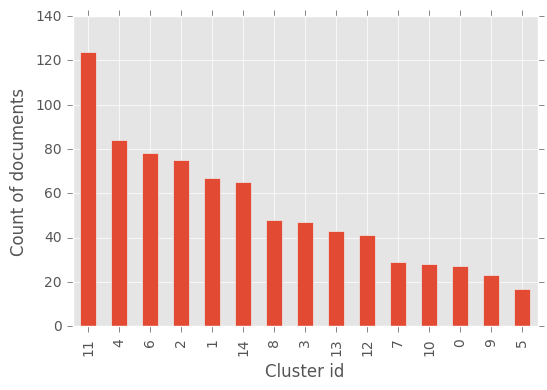

In [15]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure()
matplotlib.style.use('ggplot')
ax = frame['cluster'].value_counts().plot(kind='bar')
ax.set_ylabel('Count of documents')
ax.set_xlabel('Cluster id')
plt.show()

In [40]:
#Multidimentional scaling 
import matplotlib as mpl
from sklearn.manifold import MDS

# Create cosine distance measure
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

### Vizualizing clusters

In [42]:
# Codes borrowed from http://tools.medialab.sciences-po.fr/iwanthue/

colors15 = ["#001611","#4dff62","#910079","#ffe021","#005cc8","#f2ffa7","#46003c",
 "#62ffc1","#ff359b","#017196","#ff515b","#ccdfff","#a52d00","#ff8b9b","#550c00"]

cluster_colors = {}

for i in range(0,len(colors15)):
    cc = {
        i+1:colors15[i]
    }
    cluster_colors.update(cc)

print(cluster_colors)
print(cluster_names)

{1: '#001611', 2: '#4dff62', 3: '#910079', 4: '#ffe021', 5: '#005cc8', 6: '#f2ffa7', 7: '#46003c', 8: '#62ffc1', 9: '#ff359b', 10: '#017196', 11: '#ff515b', 12: '#ccdfff', 13: '#a52d00', 14: '#ff8b9b', 15: '#550c00'}
{1: 'price,countri,export,percent,global,region,declin,product,import,market', 2: "invest,growth,product,percent,countri,increas,infrastructur,firm,'s,labor", 3: 'bank,credit,financi,countri,euro,european,area,europ,capit,market', 4: "'s,peopl,world,imf,countri,econom,develop,global,issu,economi", 5: 'growth,economi,polici,market,emerg,emerg market,countri,fiscal,global,risk', 6: "countri,program,imf,need,'s,polici,debt,financ,support,govern", 7: 'fiscal,debt,countri,deficit,adjust,public,polici,fiscal polici,growth,govern', 8: 'rate,inflat,polici,exchang,bank,central bank,central,monetari,monetari polici,u.s.', 9: 'spend,health,public,increas,countri,program,reform,gdp,fiscal,social', 10: 'tax,countri,incom,govern,percent,reform,fiscal,price,reduc,spend', 11: "imf,'s,glob

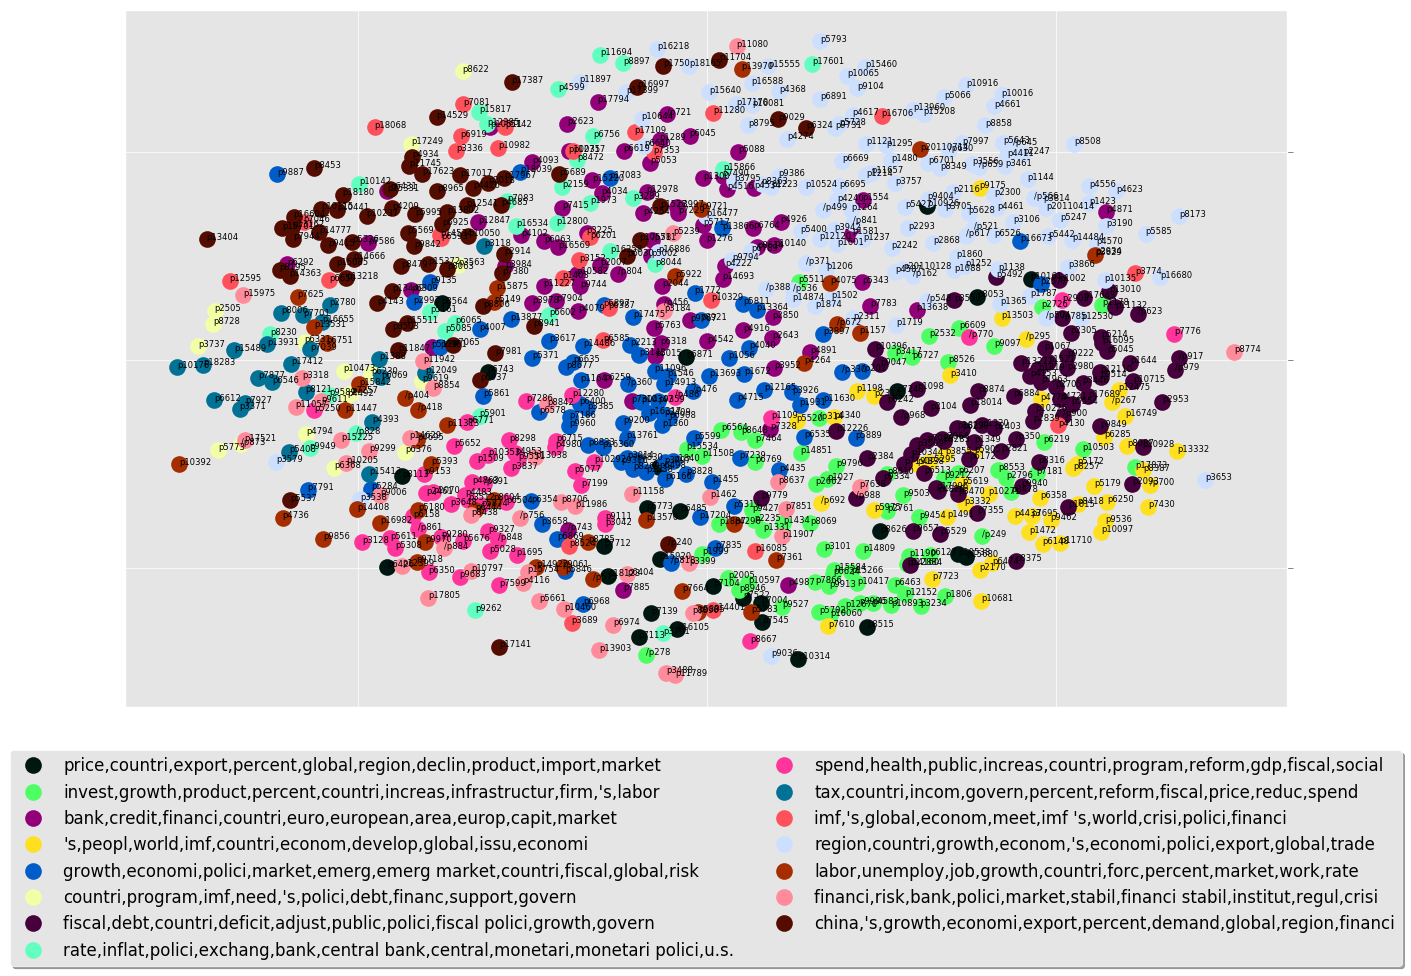

In [51]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and id
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=ides)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name+1], color=cluster_colors[name+1], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
#ax.legend(numpoints=1,loc='center left', bbox_to_anchor=(1, 0.5))  #show legend with only 1 point
#bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          # ncol=2, mode="expand", borderaxespad=0.)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=6)  
   

plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [ ]:
# TO ADD: elbow and silhouette evaluations

t-SNE: Corpus Visualization
One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. Scikit-Learn implements this decomposition method as the sklearn.manifold.TSNE transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.
Unfortunately, TSNE is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. The TSNEVisualizer creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.

In [ ]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer() 

clusters = KMeans(n_clusters=5, init='k-means++', max_iter=100)
clusters.fit(tfidf_matrix)

tsne.fit(tfidf_matrix, [matplotlib.cm.spectral(float(i) /15) for i in cluster.labels_])
tsne.poof()

In [ ]:
# Apply clustering instead of class names. 
from yellowbrick.text import TSNEVisualizer
from sklearn.cluster import KMeans 

clusters = KMeans(n_clusters=5)
clusters.fit(docs)

tsne = TSNEVisualizer() 
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

In [ ]:
from yellowbrick.text import TSNEVisualizer
# Load the data and create document vectors 
corpus = load_corpus('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(contents)
labels = corpus.target

In [ ]:
# Create the visualizer and draw the vectors 
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

In [30]:
#define custom toolbar location
import mpld3
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

### Hover over clustered chart (titles displayed!)

In [33]:

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

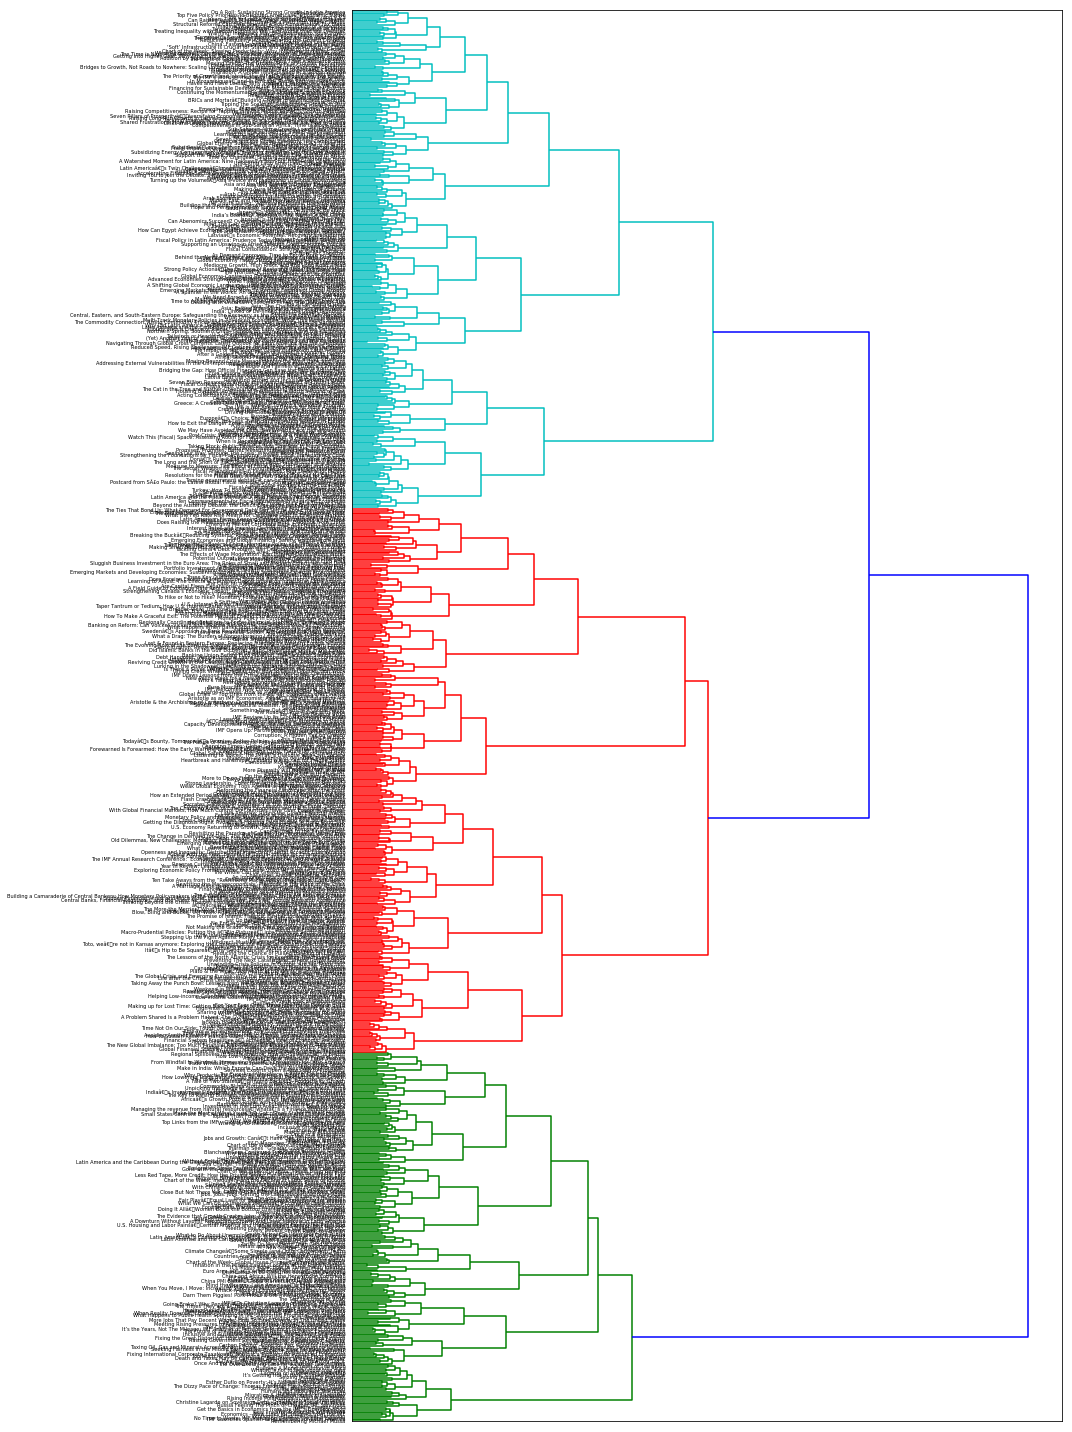

In [34]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [35]:
#strip any proper names from a text
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [36]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [39]:
from gensim import corpora, models, similarities 

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in contents]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 7.2 s, sys: 63.2 ms, total: 7.26 s
Wall time: 7.39 s
CPU times: user 11.4 s, sys: 66.8 ms, total: 11.4 s
Wall time: 11.5 s
CPU times: user 1.02 s, sys: 10.9 ms, total: 1.03 s
Wall time: 1.04 s


In [40]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

### LDA - takes long time to run - not performed yet

In [43]:
%time lda = models.LdaModel(corpus, num_topics=5,id2word=dictionary,update_every=5,chunksize=10000,passes=100)

KeyboardInterrupt: 

In [ ]:
lda.show_topics()

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()